# Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

## 0. Paper

### Info
* TItle : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks
* Author : Alec Radford et al.
* Link : https://arxiv.org/pdf/1511.06434.pdf

### Summary
* (strided) CNN, BN 등의 테크닉으로 GAN 학습 안정화

### Features
* dataset 변경 : LSUN -> Fashion mnist
* 차원 수 줄임

## 1. Setting

In [ ]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K

In [204]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'batch_size' : 128,
    'd_step_size' : 2,
    'g_step_size' : 5,
    'step_size' : 3000
}

## 2. Data

In [174]:
def prep_image(_images):
    _images = _images.astype(np.float32)
    images = np.zeros((_images.shape[0], 32, 32)).astype(np.float32) # padding
    images[:, 2:30, 2:30] = _images
    images = (2 * images - 255.0) / 255.0 # -1 ~ 1
    images = images[:,:,:,None]
    return images

In [175]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [176]:
x_train = prep_image(x_train)
x_test = prep_image(x_test)

In [177]:
x_train.shape

(60000, 32, 32, 1)

## 3. Model

In [210]:
class Generator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.fc = tf.keras.layers.Dense(2*2*128, activation='relu', kernel_initializer='random_normal')
        self.conv1 = tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', kernel_initializer='random_normal')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', kernel_initializer='random_normal')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2DTranspose(16, kernel_size=5, strides=2, padding='same', kernel_initializer='random_normal')
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.conv4 = tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', kernel_initializer='random_normal')

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    def call(self, z):
        x = self.fc(z)
        x = tf.reshape(x, (-1, 2, 2, 128)) 
        x = tf.nn.relu(self.bn1(self.conv1(x)))
        x = tf.nn.relu(self.bn2(self.conv2(x)))
        x = tf.nn.relu(self.bn3(self.conv3(x)))
        x = tf.nn.tanh(self.conv4(x))
        return x

class Discriminator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, kernel_size=5, strides=2, padding='same', kernel_initializer='random_normal')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same', kernel_initializer='random_normal')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', kernel_initializer='random_normal')
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.conv4 = tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same', kernel_initializer='random_normal')
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid')

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    
    def call(self, x):
        x = tf.nn.leaky_relu(self.bn1(self.conv1(x)))
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x)))
        x = tf.nn.leaky_relu(self.bn3(self.conv3(x)))
        x = tf.nn.leaky_relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [211]:
g = Generator()
d = Discriminator()

## 4. Train

In [212]:
@tf.function
def d_step(real, fake):
    with tf.GradientTape() as tape:
        real_loss = -tf.math.log(d(real) + 1e-7)
        fake_loss = -tf.math.log(1 - d(fake) + 1e-7)
        loss = real_loss + fake_loss
    gradients = tape.gradient(loss, d.trainable_variables)
    d.optimizer.apply_gradients(zip(gradients, d.trainable_variables))
    return tf.reduce_mean(loss)

@tf.function
def g_step(z):
    with tf.GradientTape() as tape:
        fake = g(z)
        loss = - tf.math.log(d(fake) + 1e-7)
    gradients = tape.gradient(loss, g.trainable_variables)
    g.optimizer.apply_gradients(zip(gradients, g.trainable_variables))
    return tf.reduce_mean(loss)

def post_image(images):
    images = images.numpy()
    images = (255 * images + 255) / 2
    images = images.astype(np.int32)
    images = images[:,:,:,0]
    return images 

In [ ]:
for st in range(CONFIG['step_size']):

    for _ in range(CONFIG['d_step_size']):
        z = np.random.normal(size=(CONFIG['batch_size'], 1000)).astype(np.float32)
        fake = g(z)
        real = x_train[np.random.permutation(len(x_train))[:CONFIG['batch_size']]]
        d_loss = d_step(real, fake)

    for _ in range(CONFIG['g_step_size']):
        z = np.random.normal(size=(CONFIG['batch_size'], 1000)).astype(np.float32)
        g_loss = g_step(z)

    if st % 100 == 0:
        print(f'STEP : {str(st).zfill(5)} | D Loss : {d_loss.numpy():.3f} | G Loss : {g_loss.numpy():.3f}')
        fake = post_image(fake)
        plt.imshow(fake[0])
        plt.show()

## 5. Test

In [214]:
z = np.random.normal(size=(CONFIG['batch_size'], 1000)).astype(np.float32)
images = g(z)
images = post_image(images)

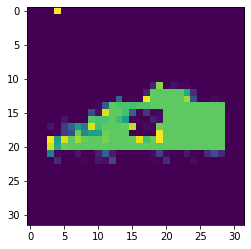

In [222]:
plt.imshow(images[0])
plt.show()